<a href="https://colab.research.google.com/github/kevinroccapriore/STEM-notebooks/blob/main/EELS_notebook_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EELS notebook v4
11.18.19

Notebook created by Kevin Roccapriore with Jordan Hachtel & Maxim Ziatdinov. 

This is a collection of analysis tools designed to interpret and help understand the information acquired from EELS studies, particularly those in the low loss spectrum.
These tools are applicable to study features such as plasmons in the visible down to NIR frequencies, but can also work for core loss features

In [1]:
#@title Imports

from tqdm import tqdm_notebook
from tqdm import tqdm
import numpy as np
import pandas as pd
import json
from pylab import cm
from scipy import interpolate
from sklearn.decomposition import NMF
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
from scipy.optimize import curve_fit
from scipy import ndimage
import operator
from scipy import signal
import matplotlib
from matplotlib.widgets import Slider, Button, RadioButtons
from mpl_toolkits import mplot3d

# stick with inline, notebook doesn't seem to work still
%matplotlib inline

In [2]:
#@title Function Definitions
def TruncateColormap(cmap = 'jet', lowerlim = 0, upperlim = 1, N=100):
    '''Cuts the upper/lower bound limits of a previously specified color map. 
    For example, user wishes to display half the jet cmap- from red to green,
    instead of from red to blue. 
    Inputs: 
        cmap: the color map to truncate
        lowerlim and upperlim: from scale from 0 to 1. lowerlim=0 and upperlim=1
        would return the identical cmap
        N number of steps
    '''
    gotcmap = plt.get_cmap(cmap)
    truncatedcolormap = LinearSegmentedColormap.from_list('list', gotcmap(np.linspace(lowerlim, upperlim, 100)),N=100)
    return truncatedcolormap

def OrganizeInput(numpy):
    SIraw = np.load(numpy)
    XY = SIraw.shape[:2]
    SIj = json.load(open(numpy[:-3]+'json','r'))
    disp = SIj['spatial_calibrations'][2]['scale']
    SIraw_flat=SIraw.reshape((np.prod(XY),SIraw.shape[2]))
    return SIraw, XY, disp, SIraw_flat
    
def LoadADF(filename):
    ADF1    = np.load(filename)
    ADF1j = json.load(open(filename[:-3]+'json','r'))
    ADF1_scale = ADF1j['spatial_calibrations'][0]['scale']
    return ADF1, ADF1_scale

def BlurSpectra_single(SIraw, sigma = 10):
    SIraw_blur_single = ndimage.filters.gaussian_filter(SIraw, sigma = sigma)
    return SIraw_blur_single

def BlurSpectra(SIraw, sigma = 10):
    SIraw_blur = np.zeros((SIraw.shape[0],SIraw.shape[1],SIraw.shape[2]))
    for i in range(SIraw.shape[0]):
        for j in range(SIraw.shape[1]):
            SIraw_blur[i,j] = ndimage.filters.gaussian_filter(SIraw[i,j,:], sigma = sigma)
    return SIraw_blur

def BlurSpectra_flat(SI, sigma = 10):
    SI_blur = np.zeros_like(SI)
    for ii in range(SI_blur.shape[0]):
        SI_blur[ii] = ndimage.filters.gaussian_filter(SI[i,:], sigma = sigma)
    return SI_blur

def CorrectNeg(SIraw, Blur = 10, Neg = -20, Pixrange = 250):
    """
    Args:
       SI = Accepts any 3-dim SI as the operated-on SI, normally raw
       Blur =   gaussian blur sigma value. Should be set 10-30
                range to avoid false peaks due to noise
       Neg =    value which is considered to be negative. 
                Generally shouldn't be set to exactly 0 (or very close,
                like -1), due to noise effects
                **this also prevents spectra which are not negative at
                all from being artificially offset**
       Pixrange = number of pixels to average (centered around most 
                negative pixel located after blurring) over for sub-
                tracting from raw data
    Returns:
       - Original SI with offset
       - Blurred SI with offset
       - Plot of original + blurred offset 
    """  
    # blurs each pixels' spectrum
    SIraw_blur = np.zeros((SIraw.shape[0],SIraw.shape[1],SIraw.shape[2]))
    for i in range(SIraw.shape[0]):
        for j in range(SIraw.shape[1]):
            SIraw_blur[i,j] = ndimage.filters.gaussian_filter(SIraw[i,j,:], sigma = Blur)
    
    # local min peak search:
    # performs scipy findpeaks function (inverts signal to find MIN), then picks out most negative
    # again, should be OK due to the blurring previously
    # Derp, I think this could've been done much easier with np.min() and np.argmin()...
    # Actually maybe not, because I set a height parameter with findpeaks.
    
    MN = np.zeros((SIraw.shape[0],SIraw.shape[1]))
    posmaxpixel = np.zeros((SIraw.shape[0],SIraw.shape[1]))     
    for i in range(SIraw_blur.shape[0]):
        for j in range(SIraw_blur.shape[1]):
            if np.amax(SIraw[i,j])<5000:
                MN[i,j] = np.nan
            else:
                posmaxpixel[i,j]= np.argmax(SIraw_blur[i,j,:])
        
                peaks,props = signal.find_peaks(-1*SIraw_blur[i,j,int(posmaxpixel[i,j]):],height = -20)
                keys = peaks.tolist()
                values = props['peak_heights'].tolist()
                peakdict = dict(zip(keys, values))     
                sorted_peakdict = sorted(peakdict.items(), key=operator.itemgetter(1))
                mostneg = np.array(sorted_peakdict[-1:])
                mostnegT = mostneg.T
                try:
                    MN[i,j] = posmaxpixel[i,j]+mostnegT[0][0] # this is the most negative pixel, value that we need   
                except IndexError:
                    MN[i,j] = np.nan # if sample TOO THICK, spectrum is noise, so will produce index error; 
                                     # this just gives that the bird by setting to NaN.

      
            
    SInc =  np.zeros_like(SIraw)      
    SInegmean = np.zeros((SIraw.shape[0],SIraw.shape[1]))        
    for i in range(SIraw_blur.shape[0]):
         for j in range(SIraw_blur.shape[1]):
            if np.isnan(MN[i,j]) == True:     # handling if sample too thick
                SInc[i,j] = SIraw[i,j]
            elif np.isnan(MN[i,j]) == False:
                SInegmean[i,j] = np.mean(SIraw_blur[i,j,int(MN[i,j]-Pixrange/2):int(MN[i,j]+Pixrange/2)])
                SInc[i,j] = SIraw[i,j] - SInegmean[i,j]
            
                
            
    # for plotting (finding scatter XY coordinates)
    x_pos, y_pos = np.zeros_like(MN), np.zeros_like(MN)
    for i in range(SIraw_blur.shape[0]):
        for j in range(SIraw_blur.shape[1]):
            if np.isnan(MN[i,j]) == True:
                x_pos[i,j] = 0
                y_pos[i,j] = 0
            else:
                x_pos[i,j] = int(MN[i,j])
                y_pos[i,j] = SIraw_blur[i,j,int(x_pos[i,j])]
    
    i,j = np.random.randint(SIraw.shape[0]), np.random.randint(SIraw.shape[1])
                                                                           
    fig = plt.figure(figsize=(16,4))
    gs = gridspec.GridSpec(1,2)
    ax1 = plt.subplot(gs[0,0])
    ax2 = plt.subplot(gs[0,1])
    
    ax1.plot(SIraw_blur[i,j,:])
    ax1.plot(SIraw[i,j], alpha = 0.5)
    ax1.set_ylim(-100,1000)
    ax1.axhline(0,color='k',ls='--',lw=1.5)
    
    if x_pos[i,j] == 0:
        ax1.annotate('No offset performed: \nCould not find negative enough value', xy = (0.5,0.7), xycoords = 'axes fraction')
    else:
        ax1.scatter(x_pos[i,j], y_pos[i,j], color = 'r')
        patch1 = patches.Rectangle((x_pos[i,j]-Pixrange/2, y_pos[i,j]-30), Pixrange, 60, linewidth = 1, edgecolor = 'red', facecolor = 'red', fill = False)
        ax1.add_patch(patch1)
    
    
    ax2.plot(SInc[i,j])
    ax2.set_ylim(-100,1000)
    ax2.axhline(0,color='k',ls='--',lw=1.5);
    
    # r'$\bf{fixed \ data}$
    
    ax1.set_title(r'$\bf{XY} = $' + r'$\bf[{},{}]$: Raw SI, blurred SI, region of averaging'.format(i,j))
    ax2.set_title(r'$\bf{XY} = $' + r'$\bf[{},{}]$: Corrected SI'.format(i,j))
    
    return SInc

def CalibrateEnergyAxis(SI,disp,style='fwhm',subfitwidth=8):
    Einit=np.arange(0,SI.shape[2])*disp
    if style=='pixel': ZLPC=np.array([[Einit[np.argmax(s)] for s in row] for row in SI])
    if style=='fwhm':
        lh,uh=[],[]
        avspec=np.average(SI,axis=(0,1))
        for row in SI:
            lh.append([]);uh.append([])
            for s in row:
                if np.amax(s)<1000: # This line is for thick samples when ZLP drops to noise levels
                    s=avspec
                lh[-1].append(Einit[np.argmin(np.abs(s[:np.argmax(s)]/np.amax(s)-0.5))])
                uh[-1].append(Einit[np.argmin(np.abs(s[np.argmax(s):]/np.amax(s)-0.5))+np.argmax(s)])
        lh=np.asarray(lh)        
        uh=np.asarray(uh)
        ZLPC=np.average([uh,lh],axis=0)
    if style=='subpixel':
        def gauss(x,a,x0,s): return a*np.exp(-(x-x0)**2/s**2)
        from scipy.optimize import curve_fit
        ZLPC=np.array([[curve_fit(gauss,Einit[np.argmax(s)-W:np.argmax(s)+W],
                               s[np.argmax(s)-W:np.argmax(s)+W]/np.amax(s))[0][1] for s in row] for row in SI])
    return np.array([[Einit-c for c in row] for row in ZLPC])
    
def CalibrateSI(EAx,SI,N=5000):
    m,M = np.amax(np.amin(EAx,axis=(2))), np.amin(np.amax(EAx,axis=(2)))
    Eout=np.linspace(m,M,N)[1:]
    Eout=np.linspace(m,M,N,endpoint=True)
    SIout=np.array([[interpolate.interp1d(e,s)(Eout) for e,s in zip(erow,srow)] for erow,srow in zip(EAx,SI)])
    return Eout,SIout
  
def FitPowerlaw(E,S,fst,fen):
    ist=np.argmin(np.abs(E-fst));ien=np.argmin(np.abs(E-fen))
    #e,s=np.append(E[is1:ie1],E[is2:ie2]),np.append(S[is1:ie1],S[is2:ie2])
    fig=plt.figure(figsize=(20,3))
    
    ax=fig.add_subplot(131)
    
    plt.plot(E,S,color='k',label='Data')
    plt.plot(E[ist:ien],S[ist:ien],marker='o',ms=7,markerfacecolor='none',markeredgecolor='r',lw=0,label='Fit Region')
    plt.legend(frameon=False,fontsize=13)
    fite=np.linspace(E[ist+1],E[ien-1],1000)
    f=interpolate.interp1d(E[ist:ien],S[ist:ien],kind='linear')
    elog=np.log(E[ist:ien][np.where(S[ist:ien]>0)])
    slog=np.log(S[ist:ien][np.where(S[ist:ien]>0)])
    plt.ylim(0,0.002)
    r,A0=np.polyfit(elog,slog,1)
    
    ax=fig.add_subplot(132)
    
    plt.plot(E[ist:],S[ist:],color='k',label='Data')
    plt.plot(E[ist:],np.exp(A0)*E[ist:]**(r),'b',lw=3,label='Power Law Fit')
    plt.tick_params(labelsize=16)
    plt.legend(frameon=False,fontsize=13)
    
    ax=fig.add_subplot(133)
    
    plt.axhline(0,color='k')
    plt.plot(E[ist:],S[ist:]-np.exp(A0)*E[ist:]**(r),color='b',label='Powerlaw Subtraction')
    plt.tick_params(labelsize=16)
    ax.set_xlabel(r'Energy Loss ($eV$)',fontsize=16)
    plt.subplots_adjust(top=1,bottom=0.06,right=1,left=0.15)
    plt.legend(frameon=False,fontsize=10,labelspacing=0.3,handlelength=1,handletextpad=0.2)
    plt.ylim(-0.0001,0.001)
    return fite,0.#,f(fite)-np.exp(a*fite**3+b*fite**2+c*fite+d)
  
def FitPowerlaw2R(E,S,fs1,fe1,fs2,fe2):
    is1=np.argmin(np.abs(E-fs1));ie1=np.argmin(np.abs(E-fe1))
    is2=np.argmin(np.abs(E-fs2));ie2=np.argmin(np.abs(E-fe2))
    e,s=np.append(E[is1:ie1],E[is2:ie2]),np.append(S[is1:ie1],S[is2:ie2])
    fig=plt.figure(figsize=(20,3))
    
    ax=fig.add_subplot(131)
    
    plt.plot(E*1000,S,color='k',label='Data')
    plt.plot(e*1000,s,marker='o',ms=7,markerfacecolor='none',markeredgecolor='r',lw=0,label='Fit Region')
    plt.legend(frameon=False,fontsize=13)
    fite=np.linspace(E[is1+1],E[ie2-1],300)
    f=interpolate.interp1d(E[is1:ie2],S[is1:ie2],kind='linear')
    nozeros=s[np.where(s>0)]
    nozeroe=e[np.where(s>0)]
    elog=np.log(nozeroe)
    slog=np.log(nozeros)
    plt.ylim(0,0.02)
    r,A0=np.polyfit(elog,slog,1)
    
    ax=fig.add_subplot(132)
    
    plt.plot(E[is1:]*1000,S[is1:],color='k',label='Data')
    plt.plot(E[is1:]*1000,np.exp(A0)*E[is1:]**(r),'b',label='Power Law Fit')
    plt.tick_params(labelsize=16)
    plt.legend(frameon=False,fontsize=13)
    
    ax=fig.add_subplot(133)
    
   # plt.plot(fite,f(fite)-np.exp(a*fite**3+b*fite**2+c*fite+d),color='r',label='Exponential Subtraction')
    plt.plot(E[is1:],S[is1:]-np.exp(A0)*E[is1:]**(r),color='b',label='Powerlaw Subtraction')
    plt.tick_params(labelsize=16)
    ax.set_xlabel(r'Energy Loss ($eV$)',fontsize=16)
    plt.subplots_adjust(top=1,bottom=0.06,right=1,left=0.15)
    plt.axhline(0,color='k')
    plt.legend(frameon=False,fontsize=10,labelspacing=0.3,handlelength=1,handletextpad=0.2)
    
    plt.ylim(-0.0001,0.001)
    
    return E[is1:],S[is1:]-np.exp(A0)*E[is1:]**(r)


## background subtraction using either 1 region or 2 regions:

def RemoveBackgroundSI(E,S,fst,fen):
    ist=np.argmin(np.abs(E-fst));ien=np.argmin(np.abs(E-fen))
    f=interpolate.interp1d(E[ist:ien],S[ist:ien],kind='linear')
    elog=np.log(E[ist:ien][np.where(S[ist:ien]>0)])
    slog=np.log(S[ist:ien][np.where(S[ist:ien]>0)])
    if len(np.where(S[ist:ien]>0)[0]) == 0.: 
        plt.plot(E[ist:],S[ist:])
        return E[ist:],np.zeros(E[ist:].shape)
    r,A0=np.polyfit(elog,slog,1)
    return E[ist:],S[ist:]-np.exp(A0)*E[ist:]**(r),
  
def RemoveBackgroundSI2R(E,S,fs1,fe1,fs2,fe2):
    is1=np.argmin(np.abs(E-fs1));ie1=np.argmin(np.abs(E-fe1))
    is2=np.argmin(np.abs(E-fs2));ie2=np.argmin(np.abs(E-fe2))
    e,s=np.append(E[is1:ie1],E[is2:ie2]),np.append(S[is1:ie1],S[is2:ie2])
    elog=np.log(e[np.where(s>0)])
    slog=np.log(s[np.where(s>0)])
    r,A0=np.polyfit(elog,slog,1)
    return E[is1:],S[is1:]-np.exp(A0)*E[is1:]**(r)

## Color Mapping
* Can easily make your own color maps below by adjusting the RGB values:
* Each color ranges from black (0,0,0), to a user specified color (i,j,k), to white (1,1,1)

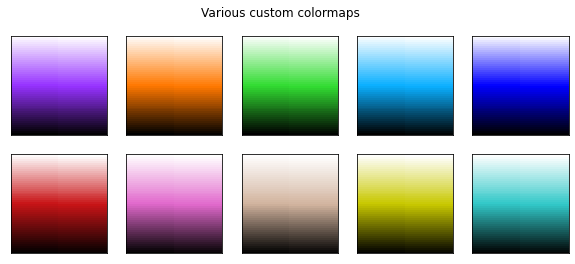

In [3]:
#@title Color Mapping
from matplotlib.colors import LinearSegmentedColormap

data1 = np.linspace(0, 1, 2500).reshape((50, 50)) # test space used to visualize colormaps below

bPw = LinearSegmentedColormap.from_list('list', [(0, 0, 0), (150./255,50/255., 1.),(1,1,1)], N=100)
bOw = LinearSegmentedColormap.from_list('list', [(0, 0, 0), (1,120./255, 0),(1,1,1)], N=100)
bGw = LinearSegmentedColormap.from_list('list', [(0, 0, 0), (50./255,220./255, 50./255),(1,1,1)], N=100)
bBw = LinearSegmentedColormap.from_list('list', [(0, 0, 0), (10./255,175/255., 1.),(1,1,1)], N=100)
bDBw = LinearSegmentedColormap.from_list('list', [(0, 0, 0), (0/255,0./255, 255/255),(1,1,1)], N=100)
bRw = LinearSegmentedColormap.from_list('list', [(0, 0, 0), (200./255,20/255., 20/225.),(1,1,1)], N=100)
bPiw = LinearSegmentedColormap.from_list('list', [(0, 0, 0), (225./255,105/255., 180/225.),(1,1,1)], N=100)
bBrw= LinearSegmentedColormap.from_list('list', [(0, 0, 0), (210./255,180/255., 140/225.),(1,1,1)], N=100)
bYw= LinearSegmentedColormap.from_list('list', [(0, 0, 0), (200./255,200/255., 0/225.),(1,1,1)], N=100)
bLGw = LinearSegmentedColormap.from_list('list', [(0, 0, 0), (50./255, 200/255, 200/255),(1,1,1)], N=100)

cmaps = [bPw,bOw,bGw,bBw,bDBw,bRw,bPiw,bBrw,bYw,bLGw]

rows = int(np.ceil(float(len(cmaps))/5))
cols = int(np.ceil(float(len(cmaps))/rows))
gs1 = gridspec.GridSpec(rows, cols)
fig = plt.figure(figsize = (2*cols, 2*(1+rows//2)))
fig.suptitle('Various custom colormaps')
for i in range(len(cmaps)):
    ax1 = fig.add_subplot(gs1[i])
    ax1.pcolormesh(data1,cmap=cmaps.pop(0))
    plt.setp([ax1], xticks = [], yticks =[])

### Import files:
* Assumes input in the form of numpy array (and metadata from json file)
    * npy file contains hyperspectral data
    * json file contains dispersion information (to calibrate energy axis)

__Note__: _users of Nion Swift will export numpy and json files_
* To do:  add more general input of data

In [4]:
# PLASMON CANYON DATASET
!gdown https://drive.google.com/uc?id=1X0By2sT1TaUunaWoSFrCyKWg0i-S0CfC
!gdown https://drive.google.com/uc?id=1XOv-th43wIDX3O-QR6EAJYHdKfI3S9VX

!gdown https://drive.google.com/uc?id=1kxXia-vmtQHq4fMvzS4IqpxeBf8JSp2R
!gdown https://drive.google.com/uc?id=1T6ZN7Z1mHEYkF9uVSPbO_FOyiCfeT1mL

Downloading...
From: https://drive.google.com/uc?id=1X0By2sT1TaUunaWoSFrCyKWg0i-S0CfC
To: /content/SI_FITO10_canyon3_highres.npy
269MB [00:03, 72.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1XOv-th43wIDX3O-QR6EAJYHdKfI3S9VX
To: /content/SI_FITO10_canyon3_highres.json
100% 5.03k/5.03k [00:00<00:00, 9.28MB/s]
Downloading...
From: https://drive.google.com/uc?id=1kxXia-vmtQHq4fMvzS4IqpxeBf8JSp2R
To: /content/HAADF_FITO10_canyon3_highres.npy
100% 132k/132k [00:00<00:00, 44.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1T6ZN7Z1mHEYkF9uVSPbO_FOyiCfeT1mL
To: /content/HAADF_FITO10_canyon3_highres.json
100% 6.56k/6.56k [00:00<00:00, 13.3MB/s]


In [5]:
#import hyperspectral file, here is an example:
!gdown https://drive.google.com/uc?id=1Pa3ORUqyr_X8Bp6BR1ecvcj76Ef1Ypru   # SI npy file  (contains hyperspectra data in (X,Y,s) format)
!gdown https://drive.google.com/uc?id=1kFiXJkIF4SFvEtX8nYQVhRYC39s7axDo   # SI json file (contains dispersion information)

!gdown  https://drive.google.com/uc?id=1rpPrP_N5orKx6gA_hzNXmvK91HTJeV9E # (HAADF npy)
!gdown  https://drive.google.com/uc?id=1wEl0AiO15tjIW230ILVyyQTOFGtx6SL1 # (HAADF json)

Downloading...
From: https://drive.google.com/uc?id=1Pa3ORUqyr_X8Bp6BR1ecvcj76Ef1Ypru
To: /content/SI_FITO_0_2x1.npy
24.0MB [00:00, 29.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1kFiXJkIF4SFvEtX8nYQVhRYC39s7axDo
To: /content/SI_FITO_0_2x1.json
100% 5.04k/5.04k [00:00<00:00, 12.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1rpPrP_N5orKx6gA_hzNXmvK91HTJeV9E
To: /content/HAADF_FITO_0_2x1.npy
100% 11.8k/11.8k [00:00<00:00, 9.55MB/s]
Downloading...
From: https://drive.google.com/uc?id=1wEl0AiO15tjIW230ILVyyQTOFGtx6SL1
To: /content/HAADF_FITO_0_2x1.json
100% 6.58k/6.58k [00:00<00:00, 5.45MB/s]


###  These functions below perform the following:
1. Grab dispersion from json file, reshape 3D datacube to 2D
2. If needed, correct for negativity in the EELS spectrum (values should not be negative, only for noise)
    * The spectra is first blurred significantly (adjust the degree by "Blur" parameter), and the most negative value is searched for. Then, a +/- range from that negative pixel is averaged, and subtracted from the entire dataset (for each x,y pixel)
    * The amount of negativity to be considered 'negative enough' can be adjusted by the "Neg" parameter
    * The amount of energy pixels to average can be adjusted by "Pixrange" parameter
3. The negative corrected data is reshaped
4. The dispersion is applied to the spectral pixels by aligning zero loss peak
5. Flatten
6. Because the ZLP wiggles around, the start and end of each spectrum may be slightly different (since they were aligned by ZLP). This step ensures all (x,y) start and end at same energy but truncating
7. Flattened spectrum image (SI)

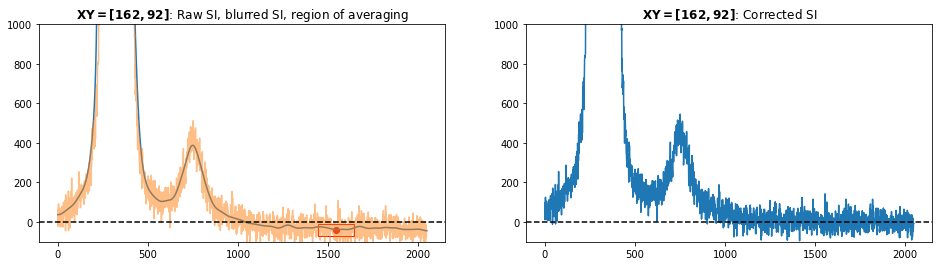

In [6]:
#import hyperspectral file:

# filename='SI_FITO_0_2x1.npy'
filename = 'SI_FITO10_canyon3_highres.npy'

SIraw, XY, disp, SIraw_flat = OrganizeInput(filename) 
SInc = CorrectNeg(SIraw, Blur = 20, Neg = -20, Pixrange = 200)
SIncflat = SInc.reshape((np.prod(XY),SInc.shape[2]))
EnergyAxes=CalibrateEnergyAxis(SInc,disp)                  # align ZLP & use dispersion to go from pixel -> eV
Eaxflat=EnergyAxes.reshape((np.prod(XY),SInc.shape[2]))    # flatten
E,SI=CalibrateSI(EnergyAxes,SInc, N = 5000)                # calibrate energies by making all pixels start and end at same energy values
SIflat=SI.reshape((np.prod(XY),SI.shape[2]))               # flatten

###  Visualize data by ZLP contrast
* select scalebar length ("sb" parameter) to be used
* if desired, adjust the x,y positions of the scalebar and text, with:
    * x0,y0 for the scalebar,
    * in the annotate command, xy=( ) for the text position

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.


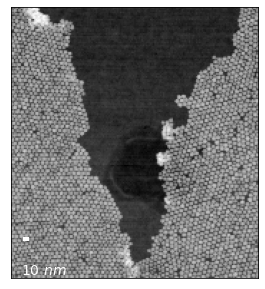

In [7]:
sb = 10 # nm

SIj = json.load(open(filename[:-3]+'json','r'))
SI_scale = SIj['spatial_calibrations'][0]['scale']
scalebar = sb / SI_scale
sbcolor = 'white'

# (x0,y0) is bottom left corner of scalebar

xx, yy = SI.shape[1], SI.shape[0]
x0, y0 = xx*0.05, yy*0.85

f,a = plt.subplots(figsize=(5,5))
gs = gridspec.GridSpec(1, 1, hspace = 0.1, wspace= 0.1)
ax1 = plt.subplot(gs[0, 0])

ax1.imshow(np.mean(SI[:,:,:],axis=2),cmap = 'gray_r') # taking mean of all pixels should essentially be all ZLP (close to ADF signal)

scalebar1 = patches.Rectangle((x0,y0), scalebar, 0.2, linewidth=3,edgecolor=sbcolor, facecolor = sbcolor)
ax1.add_patch(scalebar1);
ax1.annotate('${}$ $nm$'.format(sb), xy=(0.04,0.015), color = sbcolor, fontsize = 14, weight = 'bold', textcoords = 'axes fraction');
plt.setp([ax1], xticks = [], yticks = []);

#### This is just a visualization of how the "CalibrateEnergyAxis" (align ZLP) and "CalibrateSI" functions performed:
* Likely will need to adjust the x-limits to view before and after truncation.

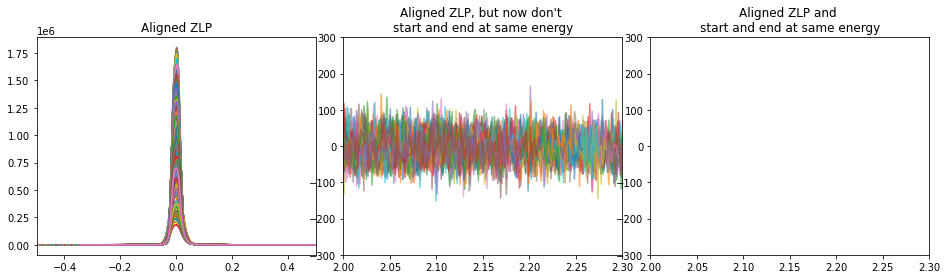

In [8]:
xlim1, xlim2 = 2,2.3

f = plt.figure(figsize=(16,4))
gs = gridspec.GridSpec(1,3,wspace=0.1,hspace=0.1)
ax1=plt.subplot(gs[0,0])
ax2=plt.subplot(gs[0,1])
ax3=plt.subplot(gs[0,2])
for e,s in zip(Eaxflat[::10],SIncflat[::10]):
    ax1.plot(e,s)
ax1.set_xlim(-0.5,0.5)
for e,s in zip(Eaxflat[::500],SIncflat[::500]):
    ax2.plot(e,s, alpha = 0.6)
ax2.set_xlim(xlim1,xlim2)
ax2.set_ylim(-300,300)
for s in SIflat[::500]: 
    ax3.plot(E,s, alpha = 0.6)
ax3.set_xlim(xlim1,xlim2)
ax3.set_ylim(-300,300)
ax1.set_title("Aligned ZLP")
ax2.set_title("Aligned ZLP, but now don't \nstart and end at same energy")
ax3.set_title("Aligned ZLP and \nstart and end at same energy");

# Background Subtract
* Can choose either 1 region or 2 region power law fit, this is typically the best we can do for low loss.
* Operate on a random pixel and check the difference between the two. 
* This may require a bit of tinkering with the limits for the fitting to obtain best result
* __For low loss, it seems that usually 2-regions is preferred__ especially if we want to keep the SiN$_x$ peak in our data
    * One region on the ZLP tail, other region on other side of SiN$_x$ or plasmon peak

### 1 region fit:

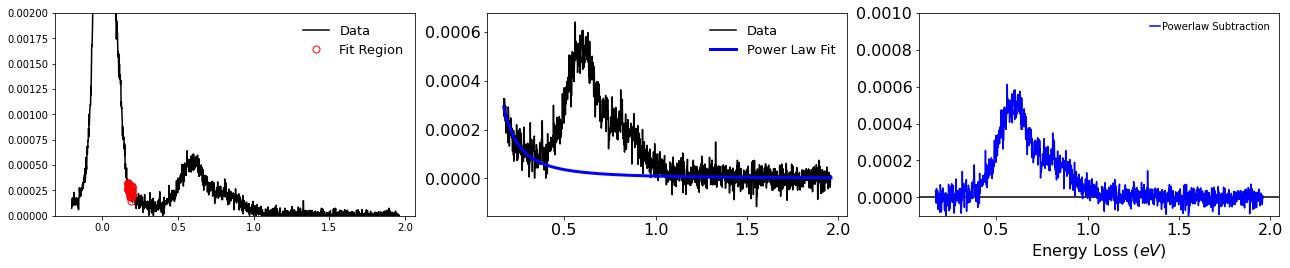

In [9]:
# limits for fitting power law (in eV) for single region
# Run this cell several times to see how other (x,y) pixels fit --> Ctrl+Enter reruns multiple times 

r1a = 0.17
r1b = 0.2
I,J=np.random.randint(SI.shape[0]),np.random.randint(SI.shape[1])
testE1,testS1=FitPowerlaw(E,SI[I,J]/np.amax(SI[I,J]),r1a,r1b)

### 2 region fit:

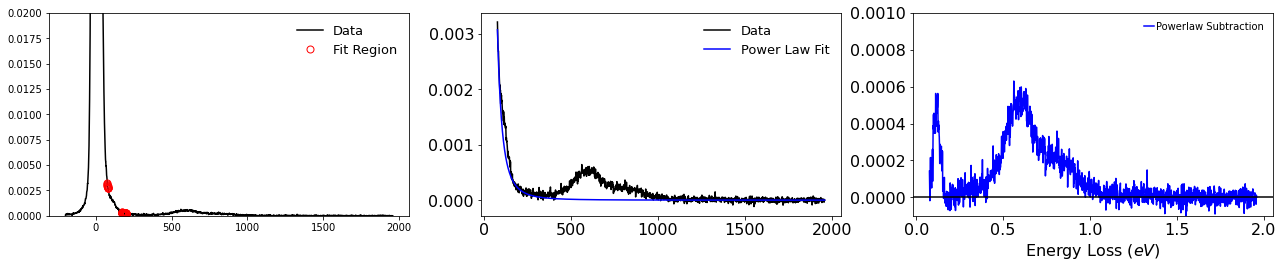

In [10]:
# limits for fitting power law (in eV) for 2 region fit
r1a = 0.0755
r1b = 0.08
r2a = 0.17
r2b = 0.2
testE1,testS1=FitPowerlaw2R(E,SI[I,J]/np.amax(SI[I,J]),r1a,r1b,r2a,r2b)

## Choose [AND EDIT] which method (1 or 2 region) to USE: 
* EDIT BELOW TO:
    * <font color=Crimson>__USE correct FUNCTION (1 or 2)__</font>, AND
    * Use correct RANGE! (correct values for r1a, r1b, r2a, r2b, etc.)

In [11]:
# Choosing 2 region fit, with specified range above

# r1a, r1b = 1.5, 1.8

r1a, r1b, r2a, r2b = 0.075, 0.08, 0.17, 0.2
NBCalc=np.asarray([[RemoveBackgroundSI2R(E,s,r1a,r1b,r2a,r2b) for s in row] for row in SI])
SINB=NBCalc[:,:,1,:]
ENB=NBCalc[0,0,0,:]
NBCalc.shape,ENB.shape,SINB.shape
SINBflat=SINB.reshape((np.prod(XY),SINB.shape[2]))

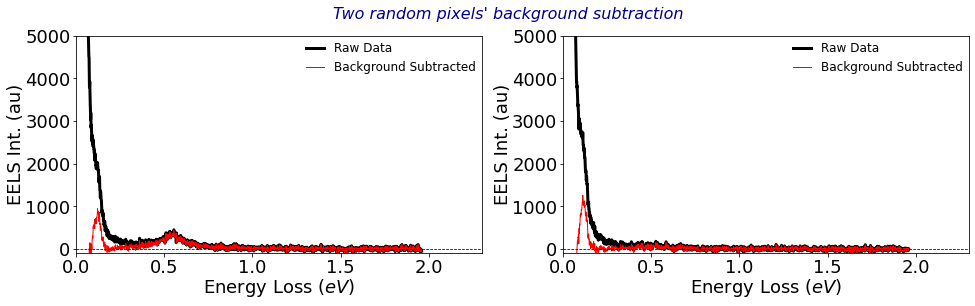

In [12]:
# two random pixels to check fit
I,J=np.random.randint(SI.shape[0]),np.random.randint(SI.shape[1])

fig = plt.figure(figsize = (16,4))
gs = gridspec.GridSpec(1,2)
ax1=plt.subplot(gs[0,0])
ax2=plt.subplot(gs[0,1])

plt.suptitle("Two random pixels' background subtraction", fontsize = 16, color = 'DarkBlue', fontstyle='italic')

ax1.plot(E,SI[I,J],color='k',lw=3,label='Raw Data')
ax1.plot(ENB,SINB[I,J],color='r',lw=1,label='Background Subtracted')
ax1.tick_params(labelsize=18,pad=2)
ax1.set_xlabel(r'Energy Loss ($eV$)',fontsize=18,labelpad=0)
ax1.set_ylabel('EELS Int. (au)',fontsize=18,labelpad=0)
ax1.axhline(0,lw=0.75,ls='--',color='k')
ax1.set_ylim(-100,5000)
ax1.set_xlim(0,xlim2)
ax1.legend(frameon=False,fontsize=12,borderpad=0,handlelength=1.5)

I,J=np.random.randint(SI.shape[0]),np.random.randint(SI.shape[1])
ax2.plot(E,SI[I,J],color='k',lw=3,label='Raw Data')
ax2.plot(ENB,SINB[I,J],color='r',lw=1,label='Background Subtracted')
ax2.tick_params(labelsize=18,pad=2)
ax2.set_xlabel(r'Energy Loss ($eV$)',fontsize=18,labelpad=0)
ax2.set_ylabel('EELS Int. (au)',fontsize=18,labelpad=0)
ax2.axhline(0,lw=0.75,ls='--',color='k')
ax2.set_ylim(-100,5000)
ax2.set_xlim(0,xlim2)
ax2.legend(frameon=False,fontsize=12,borderpad=0,handlelength=1.5);

# Energy window sliding widget for quick analysis (like is done in Swift)
* Yes this looks like a stupid-long cell, but it works in the current state... I will make more compact in future

* **If the output of the interactive plot is blank**:
* you may need to run the following cell, with the two magic commands, multiple times (Ctrl+Enter) - sometimes takes 10-20 executes, unclear why
* Or, you are running this in colab and I haven't gotten interactivity to work here yet :(

In [28]:
%matplotlib
# %matplotlib notebook

Using matplotlib backend: nbAgg


In [25]:
# enable interactivity for the sliding widget
# %matplotlib notebook

colormap = 'jet'
SPIM = SINB
EN = ENB

f = plt.figure(figsize = (10,5))
gs = gridspec.GridSpec(7,6,hspace = 0.6, wspace = 0.2)

# axes for image and spectrum
ax1 = plt.subplot(gs[0:5,0:3])
ax2 = plt.subplot(gs[0:5,4:6])

# axes for all sliders
energyslider1_ax = plt.subplot(gs[5,4:6])
energyslider2_ax = plt.subplot(gs[6,4:6])
Rx_ax = plt.subplot(gs[5,0])
Ry_ax = plt.subplot(gs[6,0])
Rwidth_ax = plt.subplot(gs[5,2])
Rheight_ax = plt.subplot(gs[6,2])

# kind of initial parameters, not sure all are even needed anymore..
x1_init, y1_init = 0, 0
w_init, h_init = 10, 10
x1, y1 = x1_init, y1_init
w, h = w_init, h_init
x2 = x1 + w
y2 = y1 + h
x1_init, y1_init = 0, 0
x2_init, y2_init = 5, 5
x_min, y_min = 0, 0
z1_min, z2_min = 0, 0
z1_init, z2_init = 0,100

x_max, y_max = SPIM.shape[0], SPIM.shape[1]
z1_max, z2_max = SPIM.shape[2], SPIM.shape[2]
e1, e2 = EN[z1_init], EN[z2_init]

idx = 1
# plot image and spectrum
avgimage = np.mean(SPIM[:,:,z1_init:z2_init],axis=2)
image1 = ax1.imshow(avgimage, cmap=colormap)
spectrum1, = ax2.plot(EN,np.mean(SPIM[int(x1):int(x2),int(y1):int(y2),:],axis=(0,1)))

energyspan = ax2.axvspan(e1, e2, color = 'r', alpha = 0.3)

ax2.axhline(0, ls='--', c='k')
# ax2.set_xlim(0,1.5)
ax2.grid(True)
ax2.set_facecolor('lightgray')

Rect = patches.Rectangle((x1,y1), w, h, edgecolor='yellow', fill=None)
ax1.add_patch(Rect)

# sliders!

energyslider1 = Slider(energyslider1_ax, 'Energy 1 (eV)', 0, EN[SPIM.shape[2]-1], valinit = 0, valfmt='%1.3f')
energyslider2 = Slider(energyslider2_ax, 'Energy 2 (eV)', 0, EN[SPIM.shape[2]-1], valinit = 1, valfmt='%1.3f')   
smin = Slider(energyslider1_ax, 'Energy 1 (eV)', 0, EN[SPIM.shape[2]-1], valinit = 0, valfmt='%1.3f')
smax = Slider(energyslider2_ax, 'Energy 2 (eV)', 0, EN[SPIM.shape[2]-1], valinit = 1, valfmt='%1.3f')

Rx = Slider(Rx_ax, 'X$_0$ pos', 0, SPIM.shape[1]-1, valinit = 0, valfmt='%1.1f')
Ry = Slider(Ry_ax, 'Y$_0$ pos', 0, SPIM.shape[0]-1, valinit = 0, valfmt='%1.1f')
Rwidth = Slider(Rwidth_ax, 'width', 1, SPIM.shape[1]-1, valinit = 10, valfmt='%1.1f')
Rheight = Slider(Rheight_ax, 'height', 1, SPIM.shape[0]-1, valinit = 10, valfmt='%1.1f')

Rx2 = Slider(Rx_ax, 'X$_0$ pos', 0, SPIM.shape[1]-1, valinit = 0, valfmt='%1.1f')
Ry2 = Slider(Ry_ax, 'Y$_0$ pos', 0, SPIM.shape[0]-1, valinit = 0, valfmt='%1.1f')
Rwidth2 = Slider(Rwidth_ax, 'width', 1, SPIM.shape[1]-1, valinit = 10, valfmt='%1.1f')
Rheight2 = Slider(Rheight_ax, 'height', 1, SPIM.shape[0]-1, valinit = 10, valfmt='%1.1f')

# grab current x-coord array of the polygon (rectangle) which defines axvspan
# then replaces those x-coords with specificed values (which will be given with energyspan)

def set_xvalues1(polygon, x0):
    _ndarray = polygon.get_xy()
    _ndarray[0:2,0] = [x0,x0]
    _ndarray[4,0] = [x0]
    polygon.set_xy(_ndarray)
def set_xvalues2(polygon, x1):
    _ndarray = polygon.get_xy()
    _ndarray[2:4, 0] = [x1, x1]
    polygon.set_xy(_ndarray)

# grab current x coords of the axvspan polygon object -- these are really the energy
# hence z coordinates - to be used in the imshow object
# so we grab those, then use them to define a new imagearray
# update original image with new array
  
# update functions!    
def update_z1(z1):
    set_xvalues1(energyspan,z1)
    fig.canvas.draw_idle()   
def update_z2(z2):
    set_xvalues2(energyspan,z2)
    fig.canvas.draw_idle()

def update(val):
    idx1 = np.abs(EN-smin.val).argmin()
    idx2 = np.abs(EN-smax.val).argmin()
    if idx1<idx2:
        image1.set_data(np.sum(SPIM[:,:,idx1:idx2],axis=2))
        image1.autoscale()
    else:
        image1.set_data(np.sum(SPIM[:,:,idx2:idx1],axis=2))
        image1.autoscale()
    fig.canvas.draw_idle()
    draw()
    
smin.on_changed(update)
smax.on_changed(update)
energyslider1.on_changed(update_z1)
energyslider2.on_changed(update_z2)

def updateRx(val):
    array = Rect.get_xy()
    yy = array[1]
    Rect.set_xy((val,yy))  
def updateRy(val):
    array = Rect.get_xy()
    xx = array[0]
    Rect.set_xy((xx,val))   
def updateRwidth(val):
    Rect.set_width(val)    
def updateRheight(val):
    Rect.set_height(val)
    
Rx.on_changed(updateRx)
Ry.on_changed(updateRy) 
Rwidth.on_changed(updateRwidth)
Rheight.on_changed(updateRheight)

def update(val):
    idx_y1 = int(Ry.val)
    idx_y2 = int(Ry.val + Rheight.val)
    idx_x1 = int(Rx.val)
    idx_x2 = int(Rx.val + Rwidth.val)
    spectrum1.set_data(EN,np.mean(SPIM[idx_y1:idx_y2, idx_x1:idx_x2, :],axis=(0,1)))
    ax2.set_ylim(0,np.max(SPIM[idx_y1:idx_y2, idx_x1:idx_x2, 200:]))
    fig.canvas.draw_idle()
    draw()  
    
Rx.on_changed(update)
Rwidth.on_changed(update)
Ry.on_changed(update)
Rheight.on_changed(update)
plt.show();
# idx = (np.abs(A-value)).argmin()  # quite useful code to go 'backwards' in indexing!

<IPython.core.display.Javascript object>

In [ ]:
# enable interactivity for the sliding widget
# %matplotlib notebook

colormap = 'jet'
SPIM = SINB
EN = ENB

f = plt.figure(figsize = (10,5))
gs = gridspec.GridSpec(7,6,hspace = 0.6, wspace = 0.2)

# axes for image and spectrum
ax1 = plt.subplot(gs[0:5,0:3])
ax2 = plt.subplot(gs[0:5,4:6])

# axes for all sliders
energyslider1_ax = plt.subplot(gs[5,4:6])
energyslider2_ax = plt.subplot(gs[6,4:6])
Rx_ax = plt.subplot(gs[5,0])
Ry_ax = plt.subplot(gs[6,0])
Rwidth_ax = plt.subplot(gs[5,2])
Rheight_ax = plt.subplot(gs[6,2])

# kind of initial parameters, not sure all are even needed anymore..
x1_init, y1_init = 0, 0
w_init, h_init = 10, 10
x1, y1 = x1_init, y1_init
w, h = w_init, h_init
x2 = x1 + w
y2 = y1 + h
x1_init, y1_init = 0, 0
x2_init, y2_init = 5, 5
x_min, y_min = 0, 0
z1_min, z2_min = 0, 0
z1_init, z2_init = 0,100

x_max, y_max = SPIM.shape[0], SPIM.shape[1]
z1_max, z2_max = SPIM.shape[2], SPIM.shape[2]
e1, e2 = EN[z1_init], EN[z2_init]

idx = 1
# plot image and spectrum
avgimage = np.mean(SPIM[:,:,z1_init:z2_init],axis=2)
image1 = ax1.imshow(avgimage, cmap=colormap)
spectrum1, = ax2.plot(EN,np.mean(SPIM[int(x1):int(x2),int(y1):int(y2),:],axis=(0,1)))

energyspan = ax2.axvspan(e1, e2, color = 'r', alpha = 0.3)

ax2.axhline(0, ls='--', c='k')
# ax2.set_xlim(0,1.5)
ax2.grid(True)
ax2.set_facecolor('lightgray')

Rect = patches.Rectangle((x1,y1), w, h, edgecolor='yellow', fill=None)
ax1.add_patch(Rect)

# sliders!

energyslider1 = Slider(energyslider1_ax, 'Energy 1 (eV)', 0, EN[SPIM.shape[2]-1], valinit = 0, valfmt='%1.3f')
energyslider2 = Slider(energyslider2_ax, 'Energy 2 (eV)', 0, EN[SPIM.shape[2]-1], valinit = 1, valfmt='%1.3f')   
smin = Slider(energyslider1_ax, 'Energy 1 (eV)', 0, EN[SPIM.shape[2]-1], valinit = 0, valfmt='%1.3f')
smax = Slider(energyslider2_ax, 'Energy 2 (eV)', 0, EN[SPIM.shape[2]-1], valinit = 1, valfmt='%1.3f')

Rx = Slider(Rx_ax, 'X$_0$ pos', 0, SPIM.shape[1]-1, valinit = 0, valfmt='%1.1f')
Ry = Slider(Ry_ax, 'Y$_0$ pos', 0, SPIM.shape[0]-1, valinit = 0, valfmt='%1.1f')
Rwidth = Slider(Rwidth_ax, 'width', 1, SPIM.shape[1]-1, valinit = 10, valfmt='%1.1f')
Rheight = Slider(Rheight_ax, 'height', 1, SPIM.shape[0]-1, valinit = 10, valfmt='%1.1f')

Rx2 = Slider(Rx_ax, 'X$_0$ pos', 0, SPIM.shape[1]-1, valinit = 0, valfmt='%1.1f')
Ry2 = Slider(Ry_ax, 'Y$_0$ pos', 0, SPIM.shape[0]-1, valinit = 0, valfmt='%1.1f')
Rwidth2 = Slider(Rwidth_ax, 'width', 1, SPIM.shape[1]-1, valinit = 10, valfmt='%1.1f')
Rheight2 = Slider(Rheight_ax, 'height', 1, SPIM.shape[0]-1, valinit = 10, valfmt='%1.1f')

# grab current x-coord array of the polygon (rectangle) which defines axvspan
# then replaces those x-coords with specificed values (which will be given with energyspan)

def set_xvalues1(polygon, x0):
    _ndarray = polygon.get_xy()
    _ndarray[0:2,0] = [x0,x0]
    _ndarray[4,0] = [x0]
    polygon.set_xy(_ndarray)
def set_xvalues2(polygon, x1):
    _ndarray = polygon.get_xy()
    _ndarray[2:4, 0] = [x1, x1]
    polygon.set_xy(_ndarray)

# grab current x coords of the axvspan polygon object -- these are really the energy
# hence z coordinates - to be used in the imshow object
# so we grab those, then use them to define a new imagearray
# update original image with new array
  
# update functions!    
def update_z1(z1):
    set_xvalues1(energyspan,z1)
    fig.canvas.draw_idle()   
def update_z2(z2):
    set_xvalues2(energyspan,z2)
    fig.canvas.draw_idle()

def update(val):
    idx1 = np.abs(EN-smin.val).argmin()
    idx2 = np.abs(EN-smax.val).argmin()
    if idx1<idx2:
        image1.set_data(np.sum(SPIM[:,:,idx1:idx2],axis=2))
        image1.autoscale()
    else:
        image1.set_data(np.sum(SPIM[:,:,idx2:idx1],axis=2))
        image1.autoscale()
    fig.canvas.draw_idle()
    draw()
    
smin.on_changed(update)
smax.on_changed(update)
energyslider1.on_changed(update_z1)
energyslider2.on_changed(update_z2)

def updateRx(val):
    array = Rect.get_xy()
    yy = array[1]
    Rect.set_xy((val,yy))  
def updateRy(val):
    array = Rect.get_xy()
    xx = array[0]
    Rect.set_xy((xx,val))   
def updateRwidth(val):
    Rect.set_width(val)    
def updateRheight(val):
    Rect.set_height(val)
    
Rx.on_changed(updateRx)
Ry.on_changed(updateRy) 
Rwidth.on_changed(updateRwidth)
Rheight.on_changed(updateRheight)

def update(val):
    idx_y1 = int(Ry.val)
    idx_y2 = int(Ry.val + Rheight.val)
    idx_x1 = int(Rx.val)
    idx_x2 = int(Rx.val + Rwidth.val)
    spectrum1.set_data(EN,np.mean(SPIM[idx_y1:idx_y2, idx_x1:idx_x2, :],axis=(0,1)))
    ax2.set_ylim(0,np.max(SPIM[idx_y1:idx_y2, idx_x1:idx_x2, 200:]))
    fig.canvas.draw_idle()
    draw()  
    
Rx.on_changed(update)
Rwidth.on_changed(update)
Ry.on_changed(update)
Rheight.on_changed(update)
plt.show();
# idx = (np.abs(A-value)).argmin()  # quite useful code to go 'backwards' in indexing!

## Grab HAADF for scalebar (( <font color='crimson'>not necessary</font> ))
* select numpy file 
* select scalebar **length**
* select scalebar **color**

In [ ]:
# haadf = 'HAADF_FITO_0_2x1.npy'
haadf = 'HAADF_FITO10_canyon3_highres.npy'
sb = 200 # nm
sbcolor = 'white'

ADF, ADFscale = LoadADF(haadf)
ADFscale
scalebar = sb / ADFscale
ADF_n = (ADF - np.min(ADF)) / np.ptp(ADF)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.


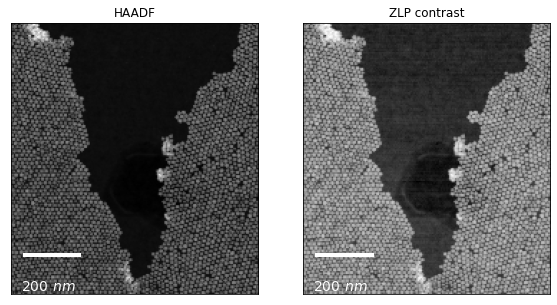

In [ ]:
xx, yy = ADF_n.shape[1], ADF_n.shape[0]
x0, y0 = xx*0.05, yy*0.85

f,a = plt.subplots(figsize=(10,5))
gs = gridspec.GridSpec(1, 2, hspace = 0.1, wspace= 0.1)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax1.imshow(ADF_n, cmap = 'gray', vmax = 1)
ax1.set_title("HAADF")

scalebar1 = patches.Rectangle((x0,y0), scalebar, 0.2, linewidth=3,edgecolor=sbcolor, facecolor = sbcolor)
ax1.add_patch(scalebar1);
ax1.annotate('${}$ $nm$'.format(sb), xy=(0.04,0.015), color = sbcolor, fontsize = 14, weight = 'bold', textcoords = 'axes fraction');
plt.setp([ax1,ax2], xticks = [], yticks = []);

ax2.imshow(np.mean(SI[:,:,:],axis=2),cmap = 'gray_r')
ax2.set_title("ZLP contrast")
scalebar2 = patches.Rectangle((x0,y0), scalebar, 0.2, linewidth=3,edgecolor=sbcolor, facecolor = sbcolor)
ax2.add_patch(scalebar2);
ax2.annotate('${}$ $nm$'.format(sb), xy=(0.04,0.015), color = sbcolor, fontsize = 14, weight = 'bold', textcoords = 'axes fraction');

# Begin some feature extraction: ML & Curve Fitting

### truncate data to begin @ 0.2 eV (cut off SiN$_x$ phonon peak)

In [ ]:
idx = (np.abs(ENB-0.200)).argmin()
ENB[idx], idx

(0.2000808120824167, 290)

* **Set truncate = 0 if you don't want to cut the data.**

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'truncated (SiN$_x$ peak removed)')

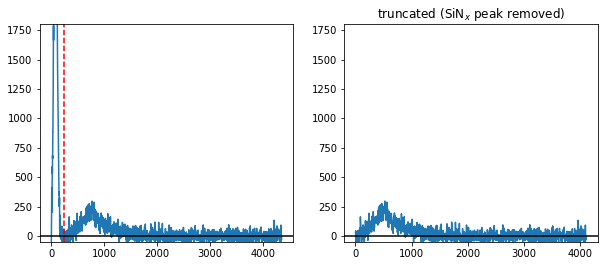

In [ ]:
truncate = idx  # adjust to line up to the right edge of silicon nitride peak (first large peak)

fig = plt.figure(figsize=(10,4))
gs = gridspec.GridSpec(1,2)
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])

ax1.plot(SINB[I,J,:])
ax1.axvline(truncate,color='red',ls='--')
ax1.axhline(0,color='k')
ax1.set_ylim(-50,1800)

ax2.plot(SINB[I,J,truncate:])

ax2.axhline(0,color='k')
ax2.set_ylim(-50,1800)
ax2.set_title('truncated (SiN$_x$ peak removed)')

In [ ]:
SINB_tr = SINB[:,:,truncate:]
ENB_tr = ENB[truncate:]

## <font color=DarkGreen>__PCA analysis__</font>
* Doesn't require any additional pre-processing than has already been done. Can immediately throw the flattened spectrum image at this

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Scree plot')

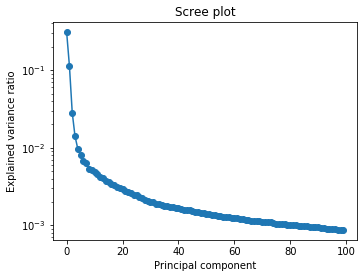

In [ ]:
fig= plt.figure(figsize=(12,4))
gs = gridspec.GridSpec(1,2)
ax1 = plt.subplot(gs[0,0])

pca = PCA()
pca.fit(SINBflat[:,truncate:])
explained_var = pca.explained_variance_ratio_

ax1.plot(explained_var[0:100], 'o-')
ax1.semilogy()
ax1.set_xlabel('Principal component')
ax1.set_ylabel('Explained variance ratio');
ax1.set_title('Scree plot')

In [ ]:
print(SINB.shape)
w, h, n = SINB.shape

(39, 75, 4357)


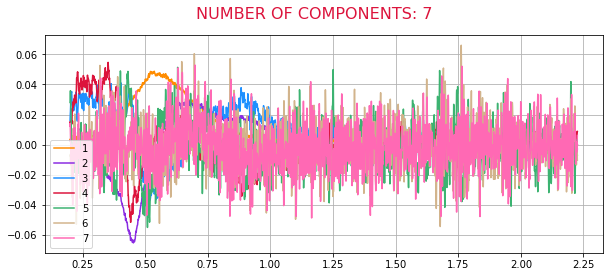

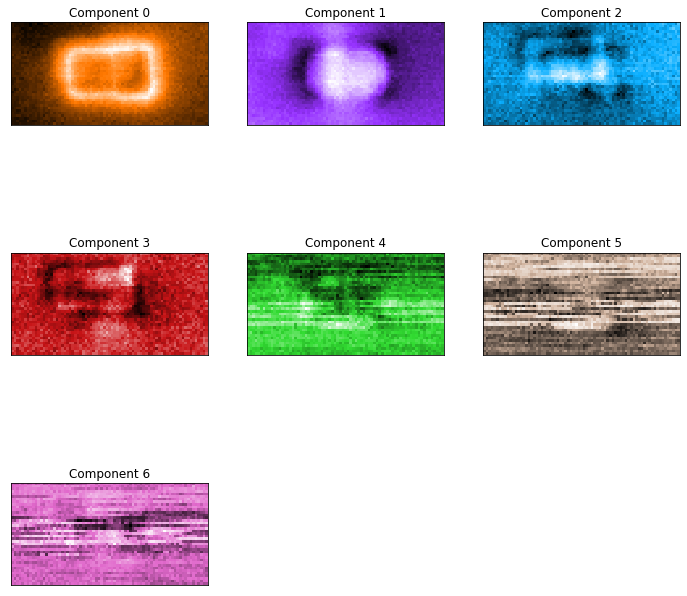

In [ ]:
%matplotlib inline


nc = 7   # select around however many high variance PCA components are shown in the scree


cmaps=[bOw, bPw, bBw, bRw, bGw, bBrw, bPiw, bYw]
colors=['DarkOrange','BlueViolet','DodgerBlue','Crimson','MediumSeaGreen','Tan','HotPink','Yellow','Black']
clf = PCA(n_components=nc)
X_vec_t = clf.fit_transform(SINBflat[:,truncate:])
components = clf.components_
X_vec_t = X_vec_t.reshape(w, h, nc)
rows = int(np.ceil(float(nc)/3))
cols = int(np.ceil(float(nc)/rows))
     
fig1,ax1 = plt.subplots(figsize = (10,4))

plt.suptitle("NUMBER OF COMPONENTS: {}".format(nc), fontsize = 16, color = 'Crimson')
for i in range(nc):
    ax1.plot(ENB_tr,components[i], color = colors.pop(0), label = i+1)
#     ax1.plot(ENB_tr,components[i], label = i)
    ax1.grid(True)
#     ax1.set_xticks(np.arange(0,3.5, step=0.1));
#     ax1.set_xlim(0.1,1.2)
    ax1.tick_params(labelsize=10)
    ax1.legend()
plt.show()

gs2 = gridspec.GridSpec(rows, cols)
fig2 = plt.figure(figsize = (4*cols, 3*(1+rows//1)))   
for i in range(nc):
    ax2 = fig2.add_subplot(gs2[i])
    ax2.imshow(X_vec_t[:, : ,i],cmap = cmaps.pop(0))
#     ax2.imshow(X_vec_t[:, : ,i],cmap = 'jet')
    ax2.set_title('Component ' + str(i))
    plt.setp([ax2],xticks=[], yticks=[])
plt.show()

## <font color=DarkGreen>__NMF analysis__</font>

* Like with PCA, restrict NMF spectral window of extraction (ignore SiN$_x$ peak)
* If there are several features spanning a few energy regions, we can do these separately (not in this case)

* Big question is <font color=Crimson>__how to handle the negative values__</font> resulting from noise centered on 0
* It can be dealt with in several ways (__all of which give a bit varied results__):

    1. Null any negative values
    2. Take absolute value of spectra
    3. Offset spectra by the most negative value
    4. Blur/denoise + combine any of the above
    5. ???

#### __1. Null any negatives (easiest to do)__

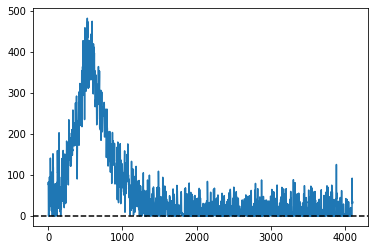

In [ ]:
plt.figure()
SIdecon=np.copy(SINBflat[:,truncate:])
SIdecon[np.where(SIdecon<0)]=0
# plt.plot(np.mean(SIdecon[:,:],axis=(0)))
plt.plot(SIdecon[500,:])
plt.axhline(0,color='k',ls='--')


In [ ]:
# For SI
N=7

model1=NMF(n_components=N)
NMFIm1=model1.fit_transform(SIdecon[:,:])
NMFSpec1=model1.components_
NMFIm1=NMFIm1.reshape(XY+(N,)).transpose(2,0,1)

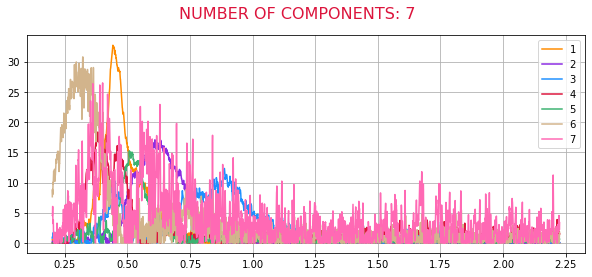

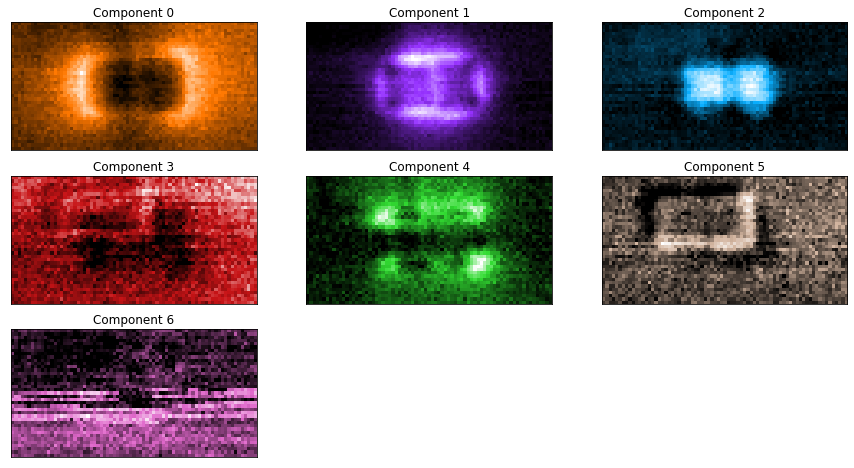

In [ ]:
colors=['DarkOrange','BlueViolet','DodgerBlue','Crimson','MediumSeaGreen','Tan','HotPink','Yellow','Black']
cmaps=[bOw,bPw,bBw,bRw,bGw,bBrw,bPiw,bYw]

rows = int(np.ceil(float(N)/3))
cols = int(np.ceil(float(N)/rows))

fig1,ax1 = plt.subplots(figsize = (10,4))

plt.suptitle("NUMBER OF COMPONENTS: {}".format(N), fontsize = 16, color = 'Crimson')
for i in range(N):
    ax1.plot(ENB_tr,NMFSpec1[i], color = colors.pop(0), label = i+1)
#     ax1.plot(ENB_tr,NMFSpec1[i], label = i)
    ax1.grid(True)
#     ax1.set_ylim(-5,60)
#     ax1.set_xticks(np.arange(0,3.5, step=0.1));
#     ax1.set_xlim(0.1,1.6)
    ax1.tick_params(labelsize=10)
    ax1.grid(True)
    ax1.legend()
plt.show()


gs2 = gridspec.GridSpec(rows, cols)
fig2 = plt.figure(figsize = (5*cols, 4*(1+rows//2)))

for i in range(N):
    ax2 = fig2.add_subplot(gs2[i])
    ax2.imshow(NMFIm1[i],cmap = cmaps.pop(0))
#     ax2.imshow(NMFIm1[i],cmap = 'magma')
    ax2.set_title('Component ' + str(i))
    plt.setp([ax2],xticks=[], yticks=[])

* After exploratory analysis, we can use the components to see where to integrate. Or just use the NMF components (they do look better and more physical)

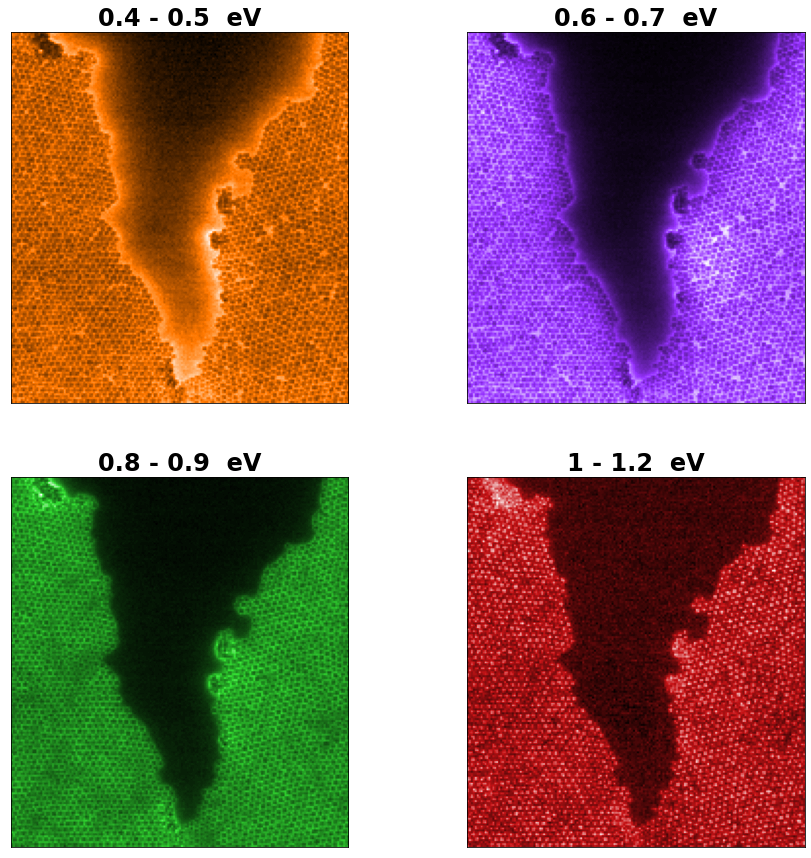

In [ ]:
# select energy integration windows, where 'a' is low end, 'b' is upper end of range
e1a, e1b = 0.4, 0.5
e2a, e2b = 0.6, 0.7
e3a, e3b = 0.8, 0.9
e4a, e4b = 1, 1.2

# convert to channel closest to the selected energy ranges
i1a, i1b = (np.abs(ENB-e1a)).argmin(), (np.abs(ENB-e1b)).argmin()
i2a, i2b = (np.abs(ENB-e2a)).argmin(), (np.abs(ENB-e2b)).argmin()
i3a, i3b = (np.abs(ENB-e3a)).argmin(), (np.abs(ENB-e3b)).argmin()
i4a, i4b = (np.abs(ENB-e4a)).argmin(), (np.abs(ENB-e4b)).argmin()

fig,ax = plt.subplots(2,2,figsize=(15,15))

ax[0,0].imshow(np.sum(SINB[:,:,i1a:i1b], axis=2), cmap = bOw)
ax[0,1].imshow(np.sum(SINB[:,:,i2a:i2b], axis=2), cmap = bPw)
ax[1,0].imshow(np.sum(SINB[:,:,i3a:i3b], axis=2), cmap = bGw)
ax[1,1].imshow(np.sum(SINB[:,:,i4a:i4b], axis=2), cmap = bRw)


ax[0,0].set_title('{} - {}  eV'.format(e1a, e1b), fontsize = 24, weight='bold')
ax[0,1].set_title('{} - {}  eV'.format(e2a, e2b), fontsize = 24, weight='bold')
ax[1,0].set_title('{} - {}  eV'.format(e3a, e3b), fontsize = 24, weight='bold')
ax[1,1].set_title('{} - {}  eV'.format(e4a, e4b), fontsize = 24, weight='bold')


plt.setp([ax[0,0],ax[0,1],ax[1,0], ax[1,1]], xticks=[], yticks=[]);

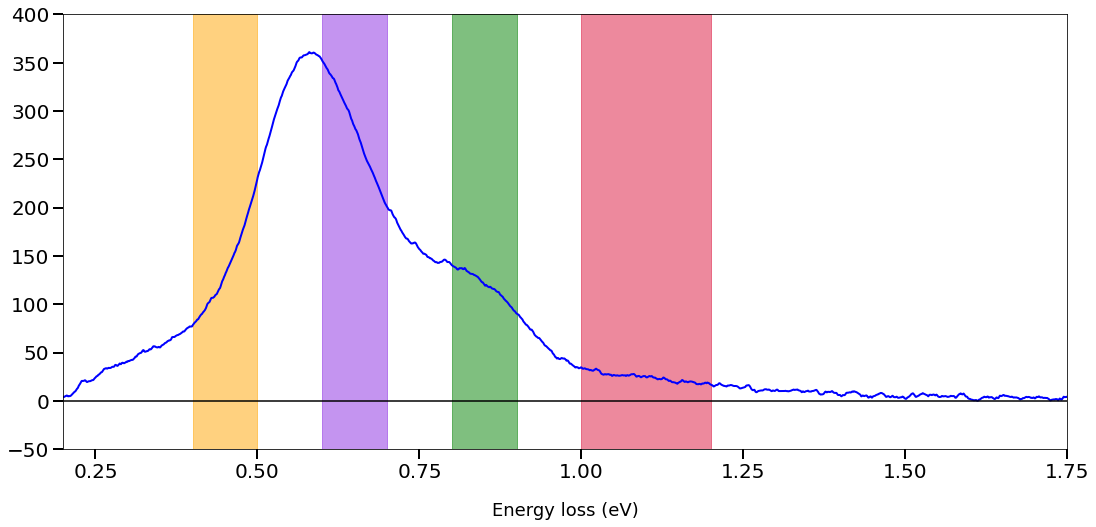

In [ ]:
plt.figure(figsize=(18,8))
plt.plot(ENB,np.mean(SINB[:,:,:],axis=(0,1)), c='blue', lw = 2)
plt.axhline(0, c='k')
plt.xlim(0.2,1.75)
plt.ylim(-50, 400)
plt.tick_params(labelsize = 20, length = 10, width = 2)
plt.xlabel('Energy loss (eV)', fontsize = 18, labelpad = 20);
plt.xticks(np.arange(0.25,2.0, step=0.25));

plt.axvspan(e1a,e1b, color = 'orange', alpha = 0.5)
plt.axvspan(e2a,e2b, color = 'blueviolet', alpha = 0.5)
plt.axvspan(e3a,e3b, color = 'green', alpha = 0.5)
plt.axvspan(e4a,e4b, color = 'crimson', alpha = 0.5)